# Brain Tumor Classification - DenseNet121 Training

This notebook trains a DenseNet121 model using both the original and external datasets with enhanced augmentation and optimization techniques:

- **AdamW Optimizer** with differential learning rates
- **ReduceLROnPlateau Scheduler**
- **Label Smoothing**
- **Data Loader Optimizations** (num_workers, pin_memory)


In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms, models
from copy import deepcopy
import matplotlib.pyplot as plt
from custom_transforms import AddGaussianNoise

# M2 MacBook: Use MPS if available, else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple Silicon GPU)")
    pin_memory = False  # Not supported on MPS yet
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: CUDA")
    pin_memory = True
else:
    device = torch.device("cpu")
    print("Using device: CPU")
    pin_memory = False

print(f"PyTorch version: {torch.__version__}")

Using device: MPS (Apple Silicon GPU)
PyTorch version: 2.8.0


In [ ]:
from pathlib import Path

BASE_DIR = Path.cwd().resolve()
while not (BASE_DIR / "data").exists() and BASE_DIR.parent != BASE_DIR:
    BASE_DIR = BASE_DIR.parent

data_dir = BASE_DIR / "data" / "Brain_Tumor_Dataset" / "Training"
external_data_dir = (
    BASE_DIR / "data" / "Brain_Tumor_Dataset" / "external_dataset" / "training"
)


In [ ]:
# Load Datasets
print("Loading datasets...")
dataset1_train = datasets.ImageFolder(root=data_dir, transform=train_tf)
dataset1_val = datasets.ImageFolder(root=data_dir, transform=val_tf)

try:
    dataset2_train = datasets.ImageFolder(root=external_data_dir, transform=train_tf)
    dataset2_val = datasets.ImageFolder(root=external_data_dir, transform=val_tf)

    full_train = ConcatDataset([dataset1_train, dataset2_train])
    full_val = ConcatDataset([dataset1_val, dataset2_val])
    print(f"Combined dataset loaded.")
except Exception as e:
    print(f"Could not load external dataset: {e}")
    full_train = dataset1_train
    full_val = dataset1_val

class_names = dataset1_train.classes
print("Classes:", class_names)
print("Total samples:", len(full_train))

Loading datasets...
Combined dataset loaded.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total samples: 14158


In [ ]:
# Create Data Loaders with Split
indices = list(range(len(full_train)))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(full_train)))
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

# Optimization: num_workers=2 (adjust based on CPU cores), pin_memory=True for faster transfer to GPU
train_loader = DataLoader(
    full_train,
    batch_size=32,
    sampler=train_sampler,
    num_workers=2,
    pin_memory=pin_memory,
)
val_loader = DataLoader(
    full_val, batch_size=32, sampler=val_sampler, num_workers=2, pin_memory=pin_memory
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 354
Validation batches: 89


In [ ]:
# Model Setup - DenseNet121
num_classes = len(class_names)

# Load DenseNet121 with pretrained weights
base = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Modify classifier head
in_features = base.classifier.in_features
base.classifier = nn.Sequential(nn.Dropout(p=0.3), nn.Linear(in_features, num_classes))

# Unfreeze all layers for better fine-tuning (Differential Learning Rate will control updates)
for p in base.parameters():
    p.requires_grad = True

model = base.to(device)

# Optimizer: AdamW with Differential Learning Rates
# Lower LR for backbone (feature extractor), Higher LR for classifier (head)
params = [
    {
        "params": [p for n, p in model.named_parameters() if "classifier" not in n],
        "lr": 1e-5,
    },
    {"params": model.classifier.parameters(), "lr": 1e-3},
]
optimizer = optim.AdamW(params, weight_decay=1e-2)

# Scheduler: Reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3
)

# Loss with Label Smoothing to prevent overfitting
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

print("DenseNet121 model ready for training on", device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to ${HOME}/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:01<00:00, 19.3MB/s]


DenseNet121 model ready for training on mps


In [ ]:
# Training Loop
epochs = 30
patience = 7  # Increased patience because of scheduler
best_val = float("inf")
bad = 0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

output_dir = "../runs"
model_dir = "../models"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

metrics_file = os.path.join(output_dir, "metrics_densenet.json")
model_save_path = os.path.join(model_dir, "brain_tumor_densenet121_trained.pt")

print("Starting training...")

for epoch in range(epochs):
    # --- Training ---
    model.train()
    tl, tc, tt = 0.0, 0, 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
        tt += y.size(0)

    train_loss = tl / tt
    train_acc = 100 * tc / tt

    # --- Validation ---
    model.eval()
    vl, vc, vt = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            vc += (out.argmax(1) == y).sum().item()
            vt += y.size(0)

    val_loss = vl / vt
    val_acc = 100 * vc / vt

    # Scheduler Step
    scheduler.step(val_loss)

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch + 1:02d} | Train {train_loss:.4f}, Acc {train_acc:.2f}% | Val {val_loss:.4f}, Acc {val_acc:.2f}%"
    )

    # Early Stopping
    if val_loss < best_val:
        best_val = val_loss
        best_state = deepcopy(model.state_dict())
        torch.save(best_state, model_save_path)
        print(f"  → Model saved to {model_save_path}")
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

print("\nTraining complete!")

Starting training...
Epoch 01 | Train 0.7714, Acc 78.19% | Val 0.5677, Acc 90.29%
  → Model saved to ../models/brain_tumor_densenet121.pt
Epoch 02 | Train 0.5950, Acc 88.82% | Val 0.5027, Acc 93.25%
  → Model saved to ../models/brain_tumor_densenet121.pt
Epoch 03 | Train 0.5402, Acc 92.05% | Val 0.4804, Acc 94.49%
  → Model saved to ../models/brain_tumor_densenet121.pt
Epoch 04 | Train 0.5131, Acc 93.48% | Val 0.4758, Acc 94.84%
  → Model saved to ../models/brain_tumor_densenet121.pt
Epoch 05 | Train 0.4954, Acc 94.39% | Val 0.4361, Acc 97.28%
  → Model saved to ../models/brain_tumor_densenet121.pt
Epoch 06 | Train 0.4790, Acc 95.22% | Val 0.4488, Acc 95.34%
Epoch 07 | Train 0.4683, Acc 95.67% | Val 0.4265, Acc 96.89%
  → Model saved to ../models/brain_tumor_densenet121.pt
Epoch 08 | Train 0.4511, Acc 96.51% | Val 0.4133, Acc 98.02%
  → Model saved to ../models/brain_tumor_densenet121.pt
Epoch 09 | Train 0.4463, Acc 96.76% | Val 0.4067, Acc 98.62%
  → Model saved to ../models/brain_tum

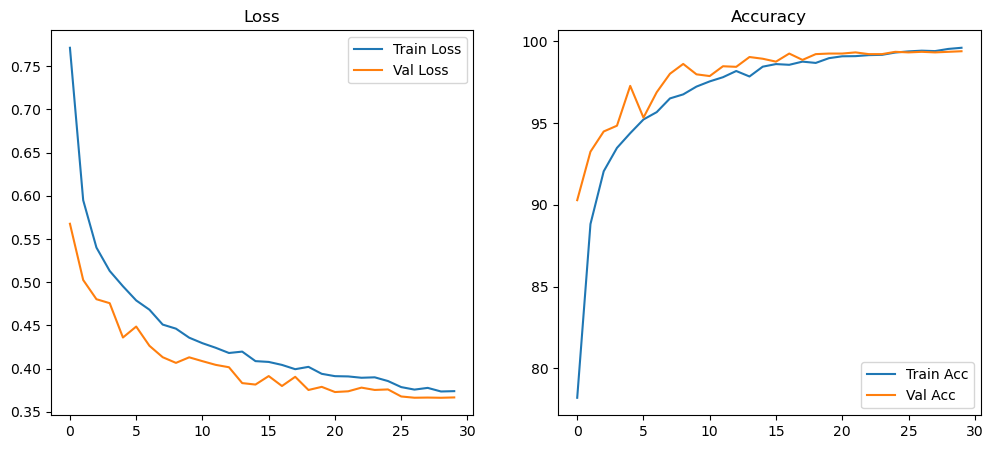

In [ ]:
# Plot Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
# Save metrics
with open(metrics_file, "w") as f:
    json.dump(history, f, indent=2)

print(f"Metrics saved to {metrics_file}")
print(f"Best validation loss: {best_val:.4f}")

Metrics saved to ../runs/metrics_densenet.json
Best validation loss: 0.3663
